In [18]:
"""SVM implementation for the first homework"""
import utils
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from plot_utils import plot_convergence, plot_SVM_sol

# Exercise II.1

0. Augment the dataset with a column of ones: for $X \in \mathbb{R}^{N \times
d}$, define $\tilde X = \begin{pmatrix} X &
1_N \end{pmatrix} \in \mathbb{R}^{N \times (d+1)}$. 
  This is usual and usefull to have compact notations and
operations: the affine operations $\langle x_i,  w\rangle + b$ is equivalent to the linear
operation $\langle \tilde x_i, \tilde w\rangle$, with $\tilde w = \begin{pmatrix} w \\ b
\end{pmatrix}$.
  All the function in the file are assuming this augmentation (for both the data
and the weights).

In [19]:
def augment(x):
    """Compute the augmented dataset
    x: (N,d) samples
    Return:
        X: (N, d+1) augmented samples (x 1)
    """
    N = x.shape[0]
    # create X = (x 1) in N x (D+1)
    X = np.concatenate((x, np.ones((N, 1))), axis=1)
    return X

1. Loss $E(w, b) = \sum_{i=1}^N \max(0, 1-t_i y_i)$ implemented on the
augmented dataset $\tilde w = \begin{pmatrix} w \\ b \end{pmatrix}$.

In [20]:
def E(W, X, t):
    """Hinge loss
    W: (d+1,) augmented weights (w;b)
    X: (N,d+1) augmented samples (x 1)
    t: (N,) targetsof size N
    """
    Y = X @ W
    return np.sum(np.maximum(0, 1- t * Y))  # element-wise maximum between two arrays

2. Subgradient 

In [21]:
def subgrad(W, X, t):
    """ Compute the subgradient of the hinge loss E at X
    W: (d+1,) augmented weights (w;b)
    X: (N,d+1) the augmented samples (x 1)
    t: (N,) targets

    Return:
        sg: (d+1,) the (mean) subgradient 

    """
    N = X.shape[0]
    Y = X@W # y_i = <x_i, w_i> + b
    Z = t*Y # targets times output of the model, should be >> 1

    Z_eq = np.where(Z==1)[0] # indices where we have to draw alpha in [-1, 0]
    alpha = np.zeros(N)      # init the alphas

    alpha[Z_eq] = -np.random.rand(*Z_eq.shape) # each alpha is iid in [-1, 0]
    alpha[Z < 1] = -1   

    SG = t.reshape(-1, 1) * alpha.reshape(-1, 1) * X  # reshape for broadcasting on D
    return SG.mean(axis=0)

Subgradient algorithm

In [22]:
def subgrad_descent(W, X, t, eta=1, max_iter=10000, tol=1e-5):
    """Subgradient descent algorithm on the SVM objective with hinge loss.
    W: (d+1,) weights
    X: (N,d+1) samples
    t: (N,) targets
    eta: learning rate
    max_iter: maximum number of iterations
    tol: tolerance to stop

    Return:
        W: (d+1,) the final weights
        qts: training quantities
    """
    cnt=0                   # iternation counter
    converged = False       # convergence criterion
    qts = defaultdict(list) # to save the results
    while not converged:
        sg = subgrad(W, X, t) # get a current subgradient
        Ek = E(W, X, t)       # current erro value

        W = W - eta * sg # update the weights
        cnt+=1           # increase the counter

        converged = cnt >= max_iter or np.linalg.norm(sg) <= tol  # test convergence
        # log values 
        qts['E'].append(Ek)                  # value of the loss
        qts['sg_norm'].append(np.linalg.norm(sg)) # norm of subgradient
        qts['cnt'] = cnt

    return W, qts

## Separable case

In [23]:
x, t = utils.gen_binary_data()  # x is NxD, t is N
N, d = x.shape

In [24]:
X = utils.augment(x)  # augment the dataset with a (N,) column of 1s 

In [25]:
W = np.zeros(d+1)  # initialize

In [26]:
# perform gradient descent
W, qts = subgrad_descent(W, X, t)
cnt = qts['cnt']  # number of iterations

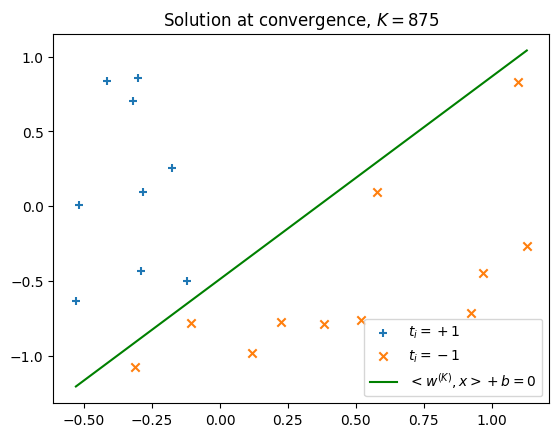

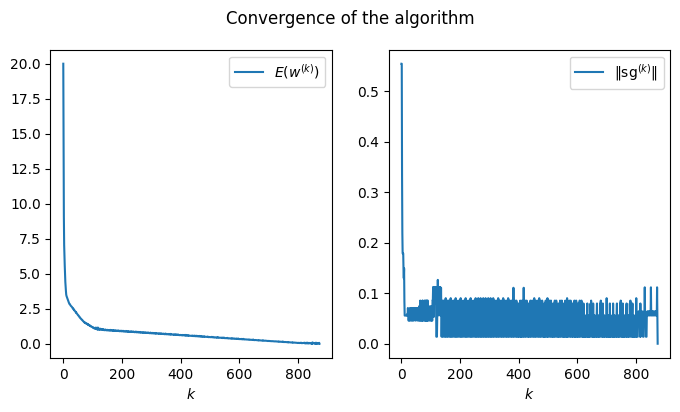

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='$k$'>, <Axes: xlabel='$k$'>], dtype=object))

In [27]:
plot_SVM_sol(W, x, t, cnt)
plot_convergence(qts['E'], qts['sg_norm'])

**Remark:** Without any constaint, the subgradient algorithm seems to find a solution with
a large margin (phenomenon sometimes termed *implicit bias* of the algorithm)

## Not separable case

In [28]:
# we flip one sample randomly in each class
pos_idx = np.where(t == 1)[0]
neg_idx = np.where(t == -1)[0]

In [29]:
# select at random
flip_idx = [np.random.choice(pos_idx), np.random.choice(neg_idx)]  

In [30]:
t[flip_idx] *= -1  # flip the elements
# recompute the problem

In [31]:
W = np.zeros(d+1)  # initialize

In [32]:
# perform gradient descent
W, qts = subgrad_descent(W, X, t)
cnt = qts['cnt']  # number of iterations

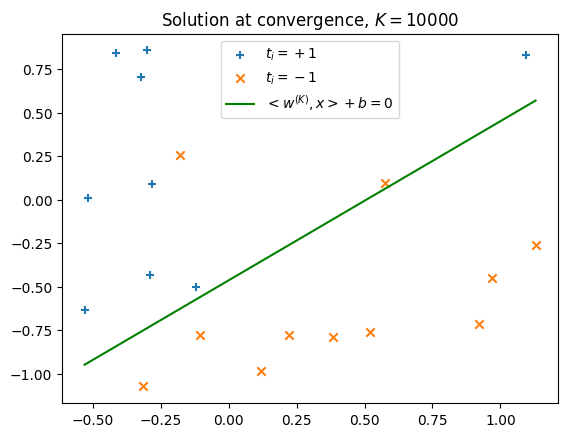

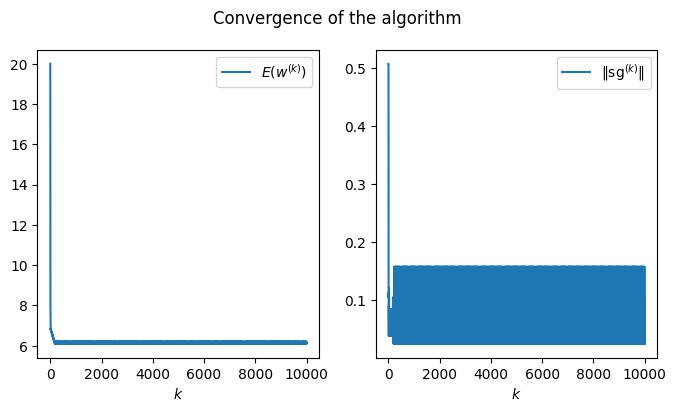

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='$k$'>, <Axes: xlabel='$k$'>], dtype=object))

In [33]:
plot_SVM_sol(W, x, t, cnt)
plot_convergence(qts['E'], qts['sg_norm'])

**Remark:** In the non separable case, the loss cannot reach 0, and the gradient keeps
oscillating  without reaching 0 norm. The solution still mostly splits the
dataset.